In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

def mape_value(y_target, y_pred):
  y_target, y_pred = np.array(y_target), np.array(y_pred)
  return np.mean(np.abs((y_target - y_pred) / y_target)) * 100


In [58]:
#aquisição da base de dados salva no github com histórico da taxa SELIC
df_selic = pd.read_csv("https://github.com/guipereira42/3DTAT_TC_FIAP_02/raw/main/dados/dados_historicos_selic.csv", sep=";", decimal=",", skipfooter=1)
#tratamento de coluna de data
df_selic['Data'] = pd.to_datetime(df_selic.Data, format='%d/%m/%Y')
#renomeando as coluans
df_selic.columns = ["data","selic_pct"]
#atribuição de indice
df_selic = df_selic.set_index("data")
df_selic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3559 entries, 2010-01-04 to 2024-03-06
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   selic_pct  3559 non-null   float64
dtypes: float64(1)
memory usage: 55.6 KB


In [59]:
#aquisição da base de dados salva no github com histórico do indíce Ibovespa
df = pd.read_csv ("https://github.com/guipereira42/3DTAT_TC_FIAP_02/raw/main/dados/dados_historicos%20_ibovespa.csv")

In [60]:
#Tratamento de dados para plotar o gráfico Selic vs Ibovespa
df_ibovespa = df
#tratamento de coluna de data
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa.Data, format='%d.%m.%Y')
#atribuição de indice
df_ibovespa = df_ibovespa.set_index("Data")
df_ibovespa.head()
df_ibovespa.columns = ["target", "abertura", "max", "min", "vol", "var_pct"]

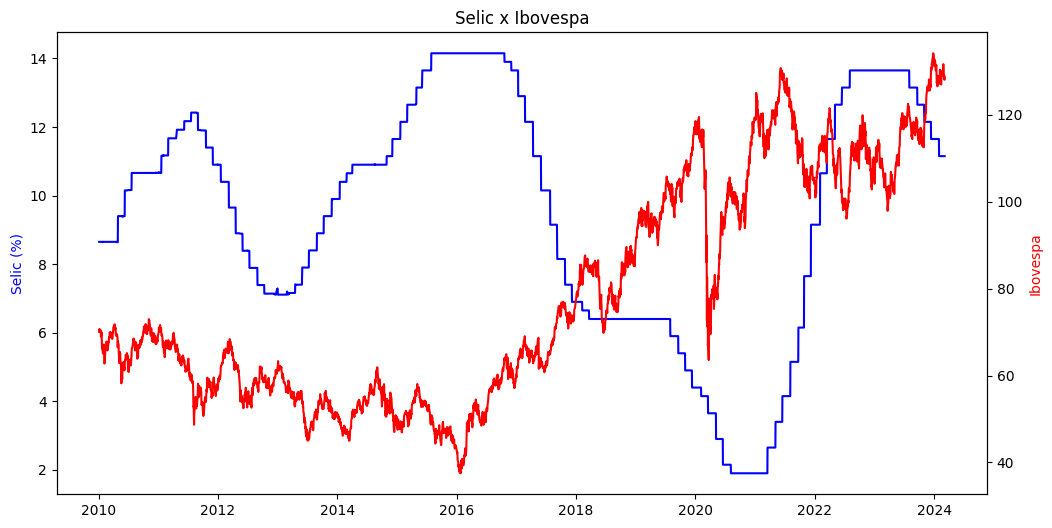

In [61]:
#plot de evolução da taxa selic e ibovespa desde 2010
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_selic["selic_pct"], label="Selic", color="blue")
ax1.set_ylabel("Selic (%)", color="blue")

ax2 = ax1.twinx()
ax2.plot(df_ibovespa["target"], label="Ibovespa", color="red")
ax2.set_ylabel("Ibovespa", color="red")

plt.title("Selic x Ibovespa", color="black")
plt.xlabel("Data", color="black")
plt.show()


##Teste de estacionariedade  Dickey Fuller

In [62]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_ibovespa['target'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.103506465484536
p-value: 0.24310697379590407
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.103506465484536
Valor-p: 0.24310697379590407
Valores Críticos:
   1%: -3.432218674967994
   5%: -2.862365674554042
   10%: -2.5672095208775207


**LSTM**


In [63]:
#Preparando o dataframe para ser utilizado no LSTM
df_ibovespa_lstm = df
df_ibovespa_lstm.rename(columns = {'Último':'target', 'Data':'date'}, inplace=True)
df_ibovespa_lstm.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True)
df_ibovespa_lstm = df_ibovespa_lstm.sort_values(by='date', ascending=True)
df_ibovespa_lstm.head()

,date,target
3510,2010-01-04,70.045
3509,2010-01-05,70.240
3508,2010-01-06,70.729
3507,2010-01-07,70.451
3506,2010-01-08,70.263


In [64]:
#Transformação dos dados em array para possibilitar o processamento pelo LSTM
close_data = df_ibovespa_lstm['target'].values
close_data = close_data.reshape(-1,1)
close_data

array([[ 70.045],
       [ 70.24 ],
       [ 70.729],
       ...,
       [128.341],
       [128.098],
       [128.89 ]])

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)
close_data

array([[0.33659783],
       [0.33861443],
       [0.34367147],
       ...,
       [0.93947072],
       [0.93695771],
       [0.94514825]])

In [66]:
#Separação em teste e treino
split_percent = 0.80
split = int(split_percent*len(close_data))
close_train = close_data[:split]
close_test = close_data[split:]
date_train = df_ibovespa_lstm['date'][:split]
date_test = df_ibovespa_lstm['date'][split:]

print(len(close_train))
print(len(close_test))

2808
703


In [67]:
from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 5
train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=15)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [68]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(19)

model=Sequential()
model.add(LSTM(200, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),
model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs=80
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/80
187/187 [==============================] - 3s 8ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 2/80
187/187 [==============================] - 2s 10ms/step - loss: 3.6808e-04 - mean_squared_error: 3.6808e-04
Epoch 3/80
187/187 [==============================] - 1s 8ms/step - loss: 5.1804e-04 - mean_squared_error: 5.1804e-04
Epoch 4/80
187/187 [==============================] - 1s 8ms/step - loss: 4.9517e-04 - mean_squared_error: 4.9517e-04
Epoch 5/80
187/187 [==============================] - 2s 10ms/step - loss: 4.8373e-04 - mean_squared_error: 4.8373e-04
Epoch 6/80
187/187 [==============================] - 2s 10ms/step - loss: 6.1895e-04 - mean_squared_error: 6.1895e-04
Epoch 7/80
187/187 [==============================] - 2s 8ms/step - loss: 6.3850e-04 - mean_squared_error: 6.3850e-04
Epoch 8/80
187/187 [==============================] - 1s 8ms/step - loss: 4.9099e-04 - mean_squared_error: 4.9099e-04
Epoch 9/80
187/187 [==============================] - 1s 8ms/

In [69]:
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

698/698 [==============================] - 2s 2ms/step - loss: 2.2750e-04 - mean_squared_error: 2.2750e-04
Erro Quadrático Médio 0.00022750429343432188


In [70]:
test_predictions = model.predict(test_generator)
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1,1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1,1))
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

mape = np.mean(np.abs((test_actuals_inv-test_predictions_inv)/test_actuals_inv))*100
print(f'MAPE: {mape:.4f}')

698/698 [==============================] - 3s 4ms/step
MAPE: 1.8800


In [71]:
rmse_value = np.sqrt(mse[0])
print("RMSE:", rmse_value)

RMSE: 0.015083245454288739


In [72]:
#Plotando o gráfico para analisar as métricas de avaliação
import plotly.graph_objects as go

prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

698/698 [==============================] - 2s 2ms/step


**PROPHET**

Plots: Série, Tendencia, Sazonalidade e Resíduos

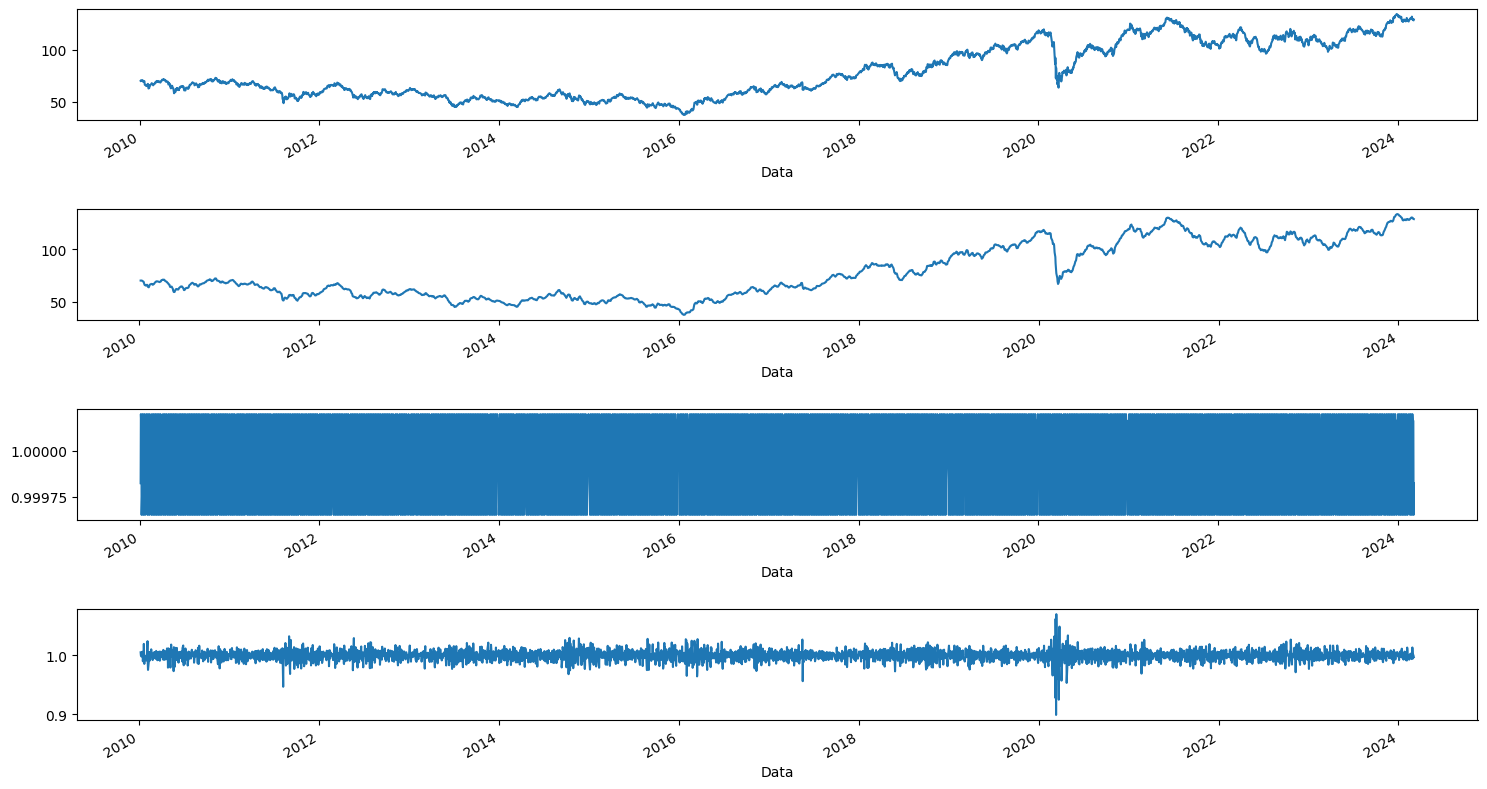

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonplot = seasonal_decompose(df_ibovespa['target'], model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## Segmentação da série temporal entre treino e teste

In [102]:
start_date = '01-Jan-2016' #início do período com caracteristica similar de estabilização e queda da taxa selic
split_date = '30-Jun-2023' #separação de base de treino e teste
ibovespa_train = df_ibovespa.loc[(df_ibovespa.index >= start_date) & (df_ibovespa.index <= split_date)].copy()
ibovespa_test = df_ibovespa.loc[df_ibovespa.index > split_date].copy()

print(f"Quantidade de registros do ibovespa_test: {len(ibovespa_test)}")
print(f"Quantidade de registros do ibovespa_train: {len(ibovespa_train)}")

Quantidade de registros do ibovespa_test: 169
Quantidade de registros do ibovespa_train: 1858


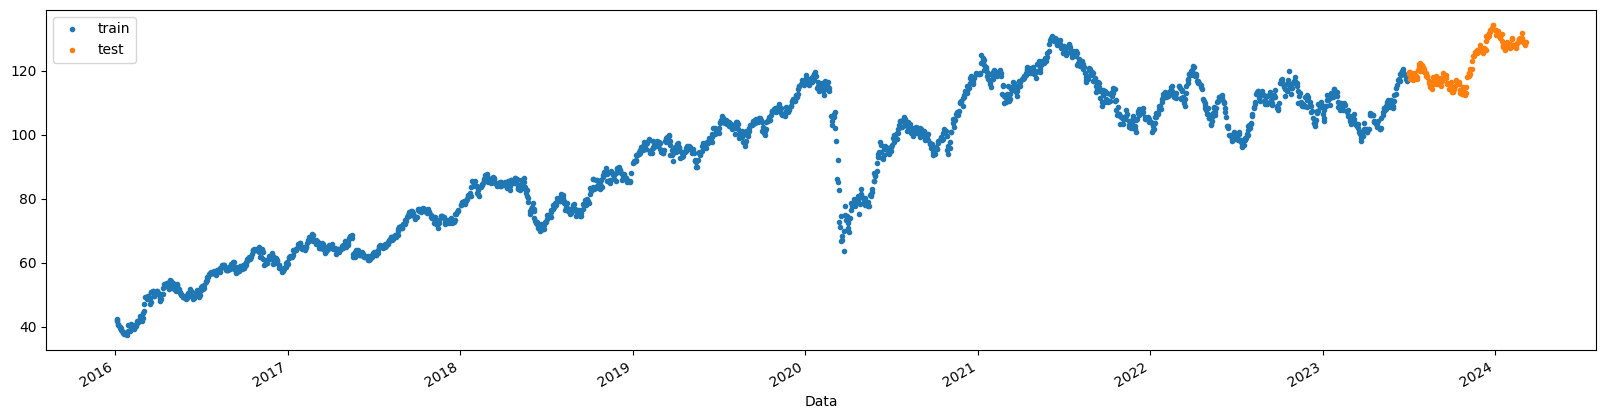

In [103]:
fig, ax = plt.subplots(figsize=(20,5))
ibovespa_train.plot(y='target',label='train', style='.', ax=ax)
ibovespa_test.plot(y='target',label='test', style='.', ax=ax)

plt.show()

## Adaptação da base para nomes requisitados pela biblioteca Prophet

In [104]:
ibovespa_train_prophet = ibovespa_train.reset_index().rename(columns={'Data':'ds', 'target':'y'})
ibovespa_train_prophet.head()

,ds,y,abertura,max,min,vol,var_pct
0,2023-06-30,118.087,118.388,119.447,118.087,"13,82M","-0,25%"
1,2023-06-29,118.383,116.683,118.623,116.683,"11,06M","1,46%"
2,2023-06-28,116.681,117.524,117.937,116.560,"10,65M","-0,72%"
3,2023-06-27,117.523,118.246,119.212,116.561,"13,08M","-0,61%"
4,2023-06-26,118.243,118.977,119.148,117.491,"10,46M","-0,62%"


## Treino do Modelo

In [105]:
model = Prophet()
model.fit(ibovespa_train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp19yghs8b/lzdu27qr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp19yghs8b/x3miwk_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8935', 'data', 'file=/tmp/tmp19yghs8b/lzdu27qr.json', 'init=/tmp/tmp19yghs8b/x3miwk_p.json', 'output', 'file=/tmp/tmp19yghs8b/prophet_modelz_lnfw0a/prophet_model-20240311222452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Teste do modelo

In [106]:
ibovespa_test_prophet = ibovespa_test.reset_index().rename(columns={'Data':'ds', 'target':'y'})
ibovespa_forecast = model.predict(ibovespa_test_prophet)

##Plot do forecast

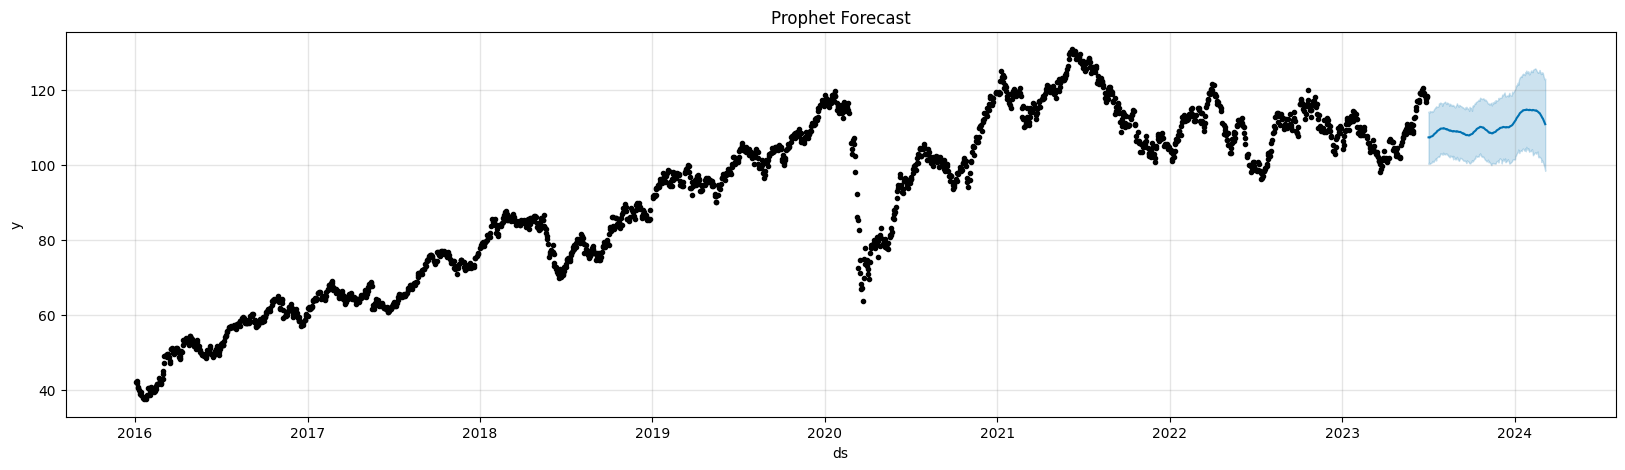

In [107]:
fig, ax = plt.subplots(figsize=(20, 5))
fig = model.plot(ibovespa_forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## plot componentes do modelo: tendência e sazonalidade

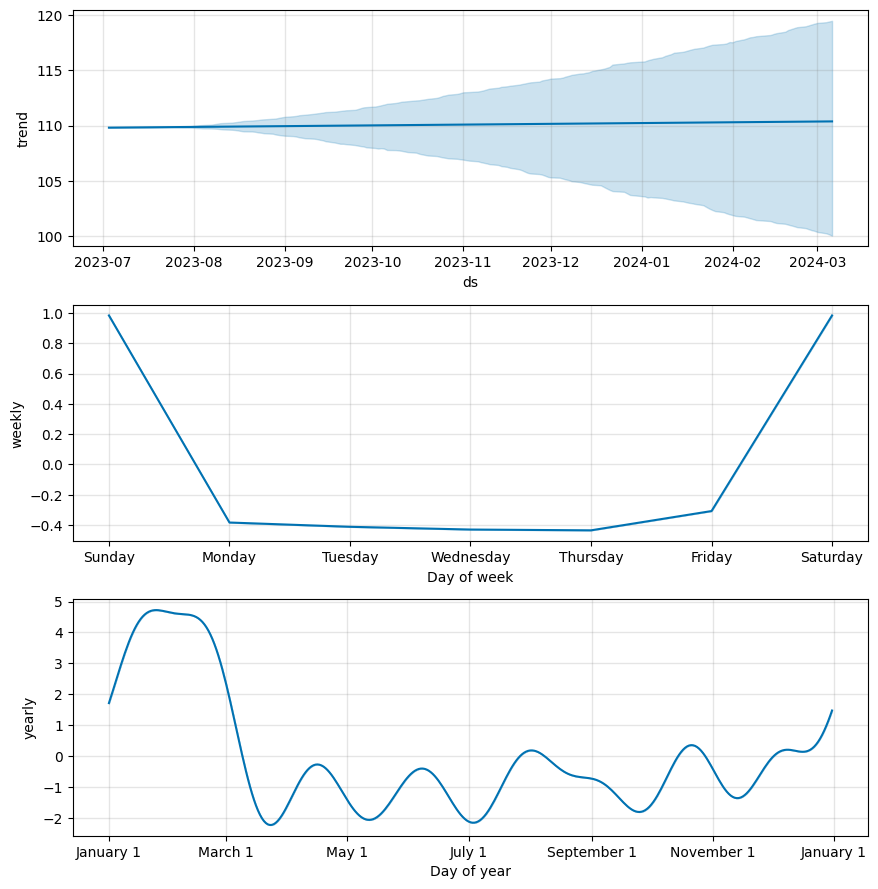

In [108]:
fig = model.plot_components(ibovespa_forecast)
plt.show()

## Comparação do forecast e valores reais

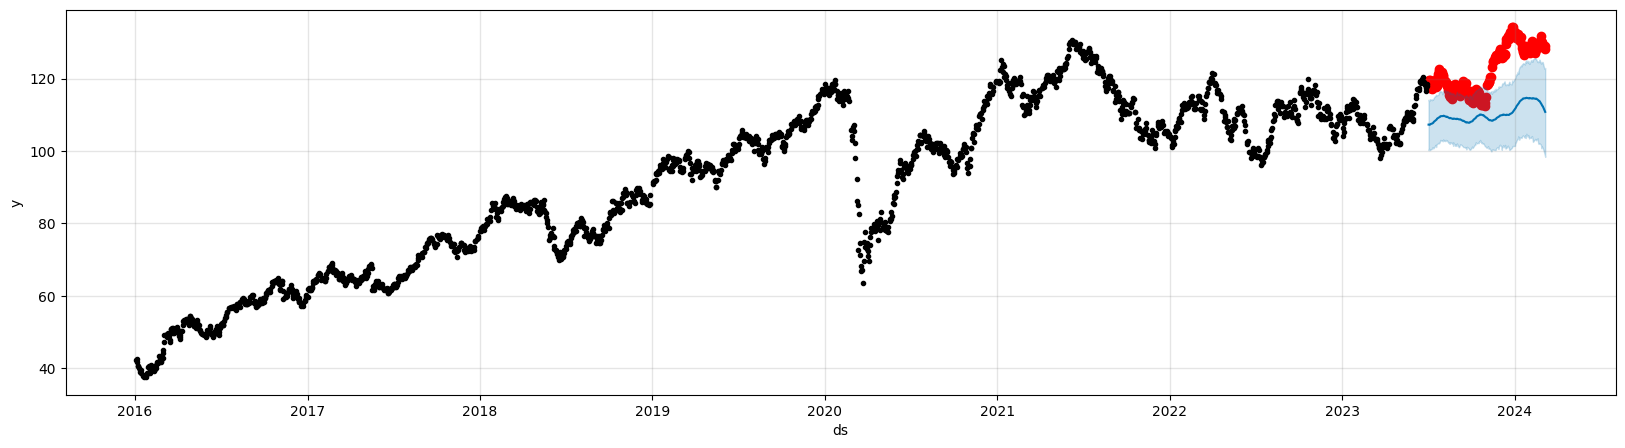

In [109]:
f, ax = plt.subplots(figsize=(20, 5))
ax.scatter(ibovespa_test.index, ibovespa_test['target'], color='r') #dados reais em vermelho
fig = model.plot(ibovespa_forecast, ax=ax)

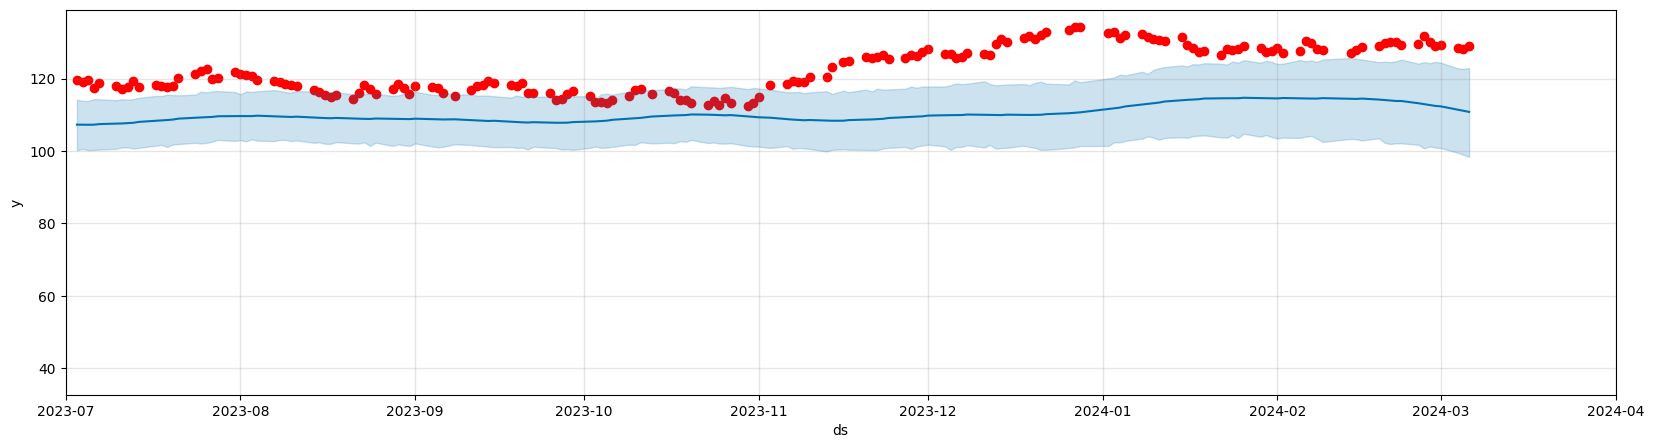

In [110]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.scatter(ibovespa_test.index, ibovespa_test['target'], color='r') #dados reais em vermelho
fig = model.plot(ibovespa_forecast, ax=ax1)
ax1.set_xbound(lower=np.datetime64('2023-07-01'),upper=np.datetime64('2024-04-01'))

## métricas de avaliação do forecast

In [111]:
mape_value(y_target=ibovespa_test['target'],y_pred=ibovespa_forecast['yhat'])

9.689644174678854

In [112]:
mean_absolute_error(y_true=ibovespa_test['target'],y_pred=ibovespa_forecast['yhat'])

12.203346437366783

In [113]:
np.sqrt(mean_squared_error(y_true=ibovespa_test['target'],y_pred=ibovespa_forecast['yhat']))

14.367856218498277